In [1]:
import cobra
from pprint import pprint
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [2]:
mitocore0= cobra.io.read_sbml_model('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Mitocore_Models/Mitocore_Original.xml')
mitocore1= cobra.io.read_sbml_model('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Mitocore_Models/Mitocore_Preliminary_Curationl.xml')
mitocore2= cobra.io.read_sbml_model('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/Mitocore/Human1_coverage/Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml')

Model does not contain SBML fbc package information.
SBML package 'layout' not supported by cobrapy, information is not parsed
SBML package 'render' not supported by cobrapy, information is not parsed
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_c "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_10fthf_m "10-Formyltetrahydrofolate">
Use of CHARGE in the notes element is discouraged, use fbc:charge instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of FORMULA in the notes element is discouraged, use fbc:chemicalFormula instead: <Species M_13dpg_c "3-Phospho-D-glyceroyl phosphate">
Use of CHARGE i

# Human1 Memote evaluation

In [2]:

! memote report snapshot --filename "Human1.html" Human-GEM.xml 

Usage: memote report snapshot [OPTIONS] MODEL

Error: Invalid value for 'MODEL': File 'Human-GEM.xml' does not exist.


# Approach counts for Human1 positives

In [35]:
def coverage_human1(model, component):

    """
    Classify Human1 ids for a specified component type in a model in Boolean dataframe

    Parameters:
    - model: COBRApy model object (e.g., mitocore)
    - component: str, one of 'reactions', 'metabolites', 'genes'
    
    Returns:
    - dataframe containing lists of positive and negative Human1 IDs.
    """
    human1_positive = []
    human1_negative = []

    for comp in getattr(model, component):
        annotations = comp.annotation  # Access the annotations of the component
        if 'Human1' in annotations and annotations['Human1']:
            # Append to the npositive list
            human1_pos_id = comp.id  
            human1_positive.append(human1_pos_id)  
        else:
            # Append to the negative list
            human1_neg_id = comp.id  
            human1_negative.append(human1_neg_id)  

    print(f"{component} positive:", len(human1_positive))
    print(f"{component} negative:", len(human1_negative))
    print(f"total {component}:", len(human1_negative) + len(human1_positive))

    #returns dataframe with counts of true 
    human1_coverage = pd.DataFrame({
        'id': human1_positive + human1_negative,
        'has_Human1': [True]*len(human1_positive) + [False]*len(human1_negative)
    })
    return human1_coverage

def counts_human1 (coverage_df, component):
    """ Count Human1 positive from boolean dataframe

    Parameters:
    - coverage_df: Boolean dataframe (True if Human1 id present, False if missing)
    - component: str ('reactions', 'metabolites', 'genes')
    
    Returns:
    - dataframe with counts total components and positive components for pie chart plot.       

    """
    total= len(coverage_df['id']) # total number of components 
    counter_positive= 0 

    for index, row in coverage_df.iterrows(): #iterate over reactions
        if row['has_Human1']: #check if 'has_Human1' is True in Boolean dataframe (True or False)
            counter_positive += 1 

    #returns dataframe with total counts and positive counts
    return pd.DataFrame({
        f"total {component}:" : [total],
        'Human1 positive': [counter_positive]
                         })

def coverage_piechart(counts_df,component):
    """
    Generate a pie chart based on the counts of Human1 positives and total components.

    Parameters:
    - counts_df: DataFrame with columns for total components and Human1 positives.

    Returns:
    - Displays a pie chart.
    """
    for index, row in counts_df.iterrows():
        # Extract values for the pie chart
        total = row.iloc[0]  # First column: total components
        positive = row.iloc[1]  # Second column: Human1 positives
        negative = total - positive  # Calculate negatives

        values = [positive, negative]
        labels = ['Human1 Positive', 'Human1 Negative']
        colors = [
    (0.36, 0.54, 0.66, 1.0),   # Slate Blue
    (0.94, 0.52, 0.40, 1.0)    # Warm Coral
]

        # Create the pie chart
        plt.figure(figsize=(8, 6))
        fig, ax = plt.subplots()
        ax.pie(values, autopct='%1.1f%%', colors=colors, startangle=90,)
       
        plt.title(f"Coverage of {component} in MitoCore with Human1 identifiers")
        ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular
        plt.grid(True)
        legend = ax.legend(labels,loc='upper left', fontsize='small', title='Human1 Coverage')
        return plt.show()


metabolites positive: 421
metabolites negative: 20
total metabolites: 441
              id  has_Human1
0       10fthf_c        True
1       10fthf_m        True
2        13dpg_c        True
3     1pipdn2c_c        True
4       1pyr5c_m        True
..           ...         ...
436        PMF_m       False
437     hcys_L_c       False
438  L2aadp6sa_c       False
439  L2aadp6sa_m       False
440       lpro_m       False

[441 rows x 2 columns]
   total metabolites:  Human1 positive
0                 441              421


<Figure size 800x600 with 0 Axes>

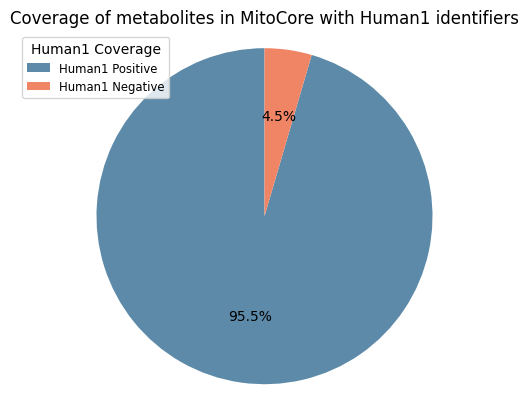

reactions positive: 395
reactions negative: 160
total reactions: 555
              id  has_Human1
0       10fthf_c        True
1       10fthf_m        True
2        13dpg_c        True
3     1pipdn2c_c        True
4       1pyr5c_m        True
..           ...         ...
436        PMF_m       False
437     hcys_L_c       False
438  L2aadp6sa_c       False
439  L2aadp6sa_m       False
440       lpro_m       False

[441 rows x 2 columns]
   total reactions:  Human1 positive
0               555              395


<Figure size 800x600 with 0 Axes>

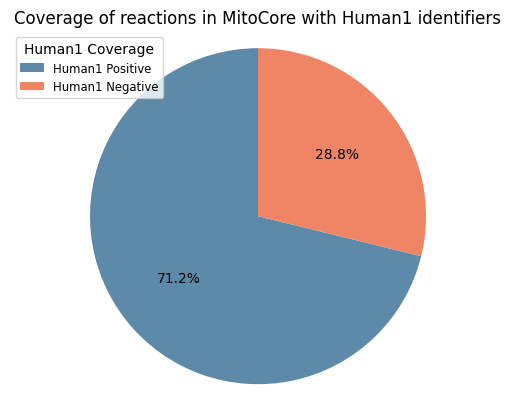

genes positive: 595
genes negative: 0
total genes: 595
                  id  has_Human1
0    ENSG00000156515        True
1    ENSG00000159399        True
2    ENSG00000160883        True
3    ENSG00000106633        True
4    ENSG00000131482        True
..               ...         ...
590  ENSG00000132874        True
591  ENSG00000141469        True
592  ENSG00000138449        True
593  ENSG00000018280        True
594  ENSG00000110911        True

[595 rows x 2 columns]
   total reactions:  Human1 positive
0               595              595


<Figure size 800x600 with 0 Axes>

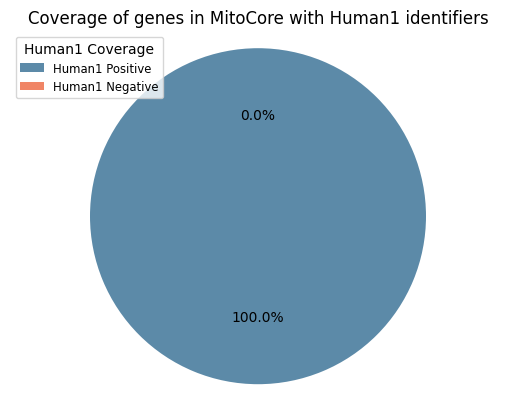

In [ ]:
mitocore = cobra.io.read_sbml_model('/Users/benjaminreyes/Desktop/Masterarbeit/neutrophil_modeling/neutrophil-modeling/curation/Cleaned_Mitocore_changed_metabolites_metanetx.chemical.xml')

met= coverage_human1(mitocore, 'metabolites')
print(met)
met_c=counts_human1 (met,'metabolites')
print(met_c)
coverage_piechart(met_c, 'metabolites')


react= coverage_human1(mitocore, 'reactions')
print(met)
react_c = counts_human1(react, 'reactions')
print(react_c)
coverage_piechart(react_c,'reactions')

genes= coverage_human1(mitocore, 'genes')
print(genes)
genes_c = counts_human1(genes, 'reactions')
print(genes_c)
coverage_piechart(genes_c,'genes')


# Check the reactions that couldn't be mapped to Human1 
1. check whit kind of reactions are not mapped to Human1
2. check which type of metabolites are not mapped to Human1 

In [78]:
def component_human(model,components ):
    """
    Classify components based on the presence of Human1 id in their annotations.

    -model: COBRApy model object
    -components: str for core components ('reactions', 'metabolites', 'genes')
    Returns:
    - tuple 2 lists: list with Human1 id, list without Human1 id)
    """
    with_human1 = []
    withouth_human1 = []

    for component in getattr(model, components):
        annotations = getattr(component, 'annotation', {})

        has_human1 = any('Human1' in key for key in annotations)

        if has_human1:
            with_human1.append(component)
        else:
            withouth_human1.append(component)

    return with_human1, withouth_human1

def is_transport_reaction(reaction):
    """collect reactions that are transport steps based on the number of compartments 
    number of compartments defined by suffix (_m, _e, _c) in metabolite id
    """

    compartments = {met.id.split("_")[-1] for met in reaction.metabolites}
    return len(compartments) > 1

def classify(model,list, model_name):
    """
    -model: SBML loaded model (mitocore0, mitocore1, mitocore2)
    -list: list of reactions to classify
    -model_name: models name
    """
    exchange = []
    transport=[]
    enzymatic=[]

    #check exchange reactions (import export, include boundary reactions)
    for reaction in list:
        if reaction in model.reactions:
            if reaction in model.boundary:
                exchange.append(reaction)

        #check transport (between compartment)
            elif is_transport_reaction(reaction):
                transport.append(reaction)
            
        #check enzymatic reactions
            else: 
                enzymatic.append(reaction)

    print(f"exchange in {model_name}: {len(exchange)}")
    print(f"transport in {model_name}: {len(transport)}")
    print(f"enzymatic in {model_name}: {len(enzymatic)}")

In [ ]:
#1. check whit kind of reactions are not mapped to Human1

reacts_wit, react_without= component_human(mitocore2, 'reactions')
print(len(reacts_wit), len(react_without))

print(len)
class_reacts_Mito2= classify(mitocore2, react_without, 'MitoCore2')



395 160
<built-in function len>
exchange in MitoCore2: 70
transport in MitoCore2: 56
enzymatic in MitoCore2: 34


In [157]:
# 2. check which type of metabolites are not mapped to Human1

mets_with, mets_without= component_human(mitocore2, 'metabolites')
print(len(mets_with), len(mets_without))



react_from_mets_not_found = set()
for met in mets_without:
    #print(met.id)
    for reaction in mitocore2.reactions:
        if met in reaction.metabolites:
            react_from_mets_not_found.add(reaction)
print('number of reactions using metabolites withouth Human1 id:',len(react_from_mets_not_found))


react_has_human1= []
react_has_not_human1= []
for react in react_from_mets_not_found:
    annotations = getattr(react, 'annotation', {})
    human1_value = annotations.get('Human1', None)
    # Only append if Human1 key exists and value is a non-empty string
    if human1_value:
        react_has_human1.append(react)
        #print(react.id)
    else:
        react_has_not_human1.append(react)
        #print(react.id)

print('number of reactions with Human1 id, using metabolites with no Human1 id: ',len(react_has_human1))
print('number of reactions with no Human1 id, using metabolites with no Human1 id: ',len(react_has_not_human1))


421 20
number of reactions using metabolites withouth Human1 id: 75
number of reactions with Human1 id, using metabolites with no Human1 id:  52
number of reactions with no Human1 id, using metabolites with no Human1 id:  23


TCYNTtmB_MitoCore
2AMADPTmC_MitoCore
CHLtmB_MitoCore
BHBtmB_MitoCore
HIBDm
CYANt
ILETAm
CYANtm
PPAtmB_MitoCore
MCPSTm_MitoCore
r2402B_MitoCore
ARGtmB_MitoCore
C160CPT1
MCPST
2AMADPTmB_MitoCore
CLS_hsm_MitoCore
ACACt2mB_MitoCore
NNT_MitoCore
2OXOADPTmC_MitoCore
2OXOADPTmB_MitoCore
FE2tm
PYRt2m
r1155
HtmB_MitoCore
CIII_MitoCore
LYStmB_MitoCore
RE1254C
r0594
BUTt2mB_MitoCore
OIVD3m
CITtbm
r0525
CITtamB
FUMtmB_MitoCore
CIV_MitoCore
PHEMEtm
GLYC3Ptm
C160CPT2
ASPGLUmB_MitoCore
ATPtmB_MitoCore
ORNt4mB_MitoCore
AASAD3m
ECOAH12m
GCCam
PIt2mB_MitoCore
ORNt3mB_MitoCore
PCREATtmdiffirB_MitoCore
CYSTS
CV_MitoCore
GLUt2mB_MitoCore
r2398B_MitoCore
AHC
number of reactions with Human1 id, using metabolites with no Human1 id  52
number of reactions with no Human1 id, using metabolites with no Human1 id  23


In [153]:
AMCOXO = mitocore2.reactions.get_by_id('CI_MitoCore')
annotation = getattr(AMCOXO, 'annotation', {})
Human1 = annotation.get('Human1')
print(annotation)
print(Human1)


{'ec-code': ['1.6.5.3', '1.6.5.8', '1.6.5.9'], 'kegg.reaction': 'R02163 (R00281 + R02166)', 'metanetx.reaction': 'MNXR101867', 'bigg.reaction': 'NADH2_u10m'}
None
